In [50]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulate example trace with instantaneous jump
To test out the step finding methods, I am simulating a trace with gaussian noise and a single instantaneous step.

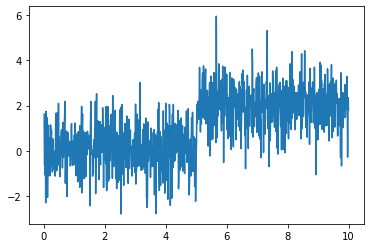

In [51]:
dt = 0.01
step_size = 2
np.random.seed(1)
trace = np.random.normal(size=1000)
trace[500:] += step_size
time = np.arange(dt,trace.size*dt+dt,dt)
plt.plot(time,trace)

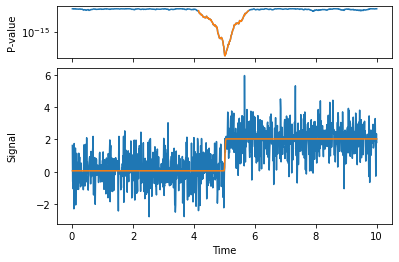

In [52]:
from stepy.methods import fit_signal
fs = fit_signal(trace, dt=dt)
fs.fit()
fs.plot()

## Simulate a trace with a linear step
To test out the step finding methods, I am simulating a trace with gaussian noise and a single linear step.

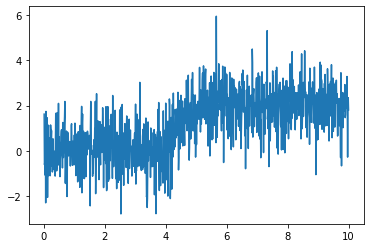

In [53]:
def linear_step_func(x, x0, x1,dy):
    y = np.piecewise(x, [
        x < x0,
        (x >= x0) & (x <= x1),
        x > x1],
        [0.,
            lambda x: x/(x1-x0)+x0/(x0-x1),
         1.]
    )
    return dy*y
dt = 0.01
step_size = 2
np.random.seed(1)
noise = np.random.normal(size=1000)
time = np.arange(dt,noise.size*dt+dt,dt)
trace = linear_step_func(time,4,5,2) + noise
plt.plot(time,trace)

{'step_height': [1.9679416339647218],
 'step_width': [0.9484588514652258],
 'dwell_time': [0],
 'step_rate': [2.0748835133169448],
 'step_start': [3.970004337157805]}

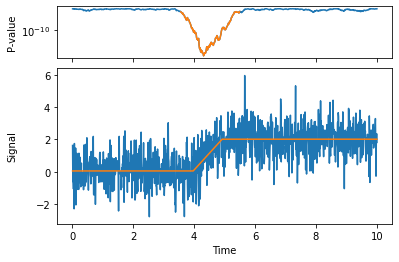

In [63]:
from stepy.methods import fit_signal
fs = fit_signal(trace, dt=dt)
fs.fit()
fs.plot()
fs.results

You can access the result using fs.output.params for the lmfit output or fs.results for a dictionary of results.

In [64]:
fs.output.params

name,value,standard error,relative error,initial value,min,max,vary
c,0.04550504,0.04937433,(108.50%),-0.09714089080609985,-inf,inf,True
s0_amplitude,1.96794163,0.06583647,(3.35%),6.542949651228245,-inf,inf,True
s0_center,3.97000434,0.09930179,(2.50%),4.525,-inf,inf,True
s0_sigma,0.94845885,0.17100669,(18.03%),0.9650000000000001,0.00000000,1.93000000,True


In [65]:
fs.results

{'step_height': [1.9679416339647218],
 'step_width': [0.9484588514652258],
 'dwell_time': [0],
 'step_rate': [2.0748835133169448],
 'step_start': [3.970004337157805]}